In [1]:
from splat.read_colmap import read_images_text, qvec2rotmat
from splat.gaussians import Gaussians
from splat.gaussian_scene import GaussianScene
import pycolmap
import torch
import torch.nn as nn
import numpy as np

from splat.utils import read_images_text, read_images_binary

colmap_path = "treehill/sparse/0"
reconstruction = pycolmap.Reconstruction(colmap_path)

points3d = reconstruction.points3D
images = read_images_binary(f"{colmap_path}/images.bin")
cameras = reconstruction.cameras

all_points3d = []
all_point_colors = []

for idx, point in enumerate(points3d.values()):
    if point.track.length() >= 2:
        all_points3d.append(point.xyz)
        all_point_colors.append(point.color)

gaussians = Gaussians(
    torch.Tensor(all_points3d),
    torch.Tensor(all_point_colors),
    model_path="point_clouds",
)
scene = GaussianScene(
    colmap_path=colmap_path,
    gaussians=gaussians,
)

/var/folders/5t/lqp_tbx57bl8lb0cbbxb2sv80000gn/T/ipykernel_26096/3315049713.py:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  torch.Tensor(all_points3d),


# Renders all points in the scene

In [2]:
from matplotlib import pyplot as plt

image_num = 100

processed_scene = scene.preprocess(image_num)
plt.scatter(
    processed_scene.points_xy[:, 0].detach().cpu(),
    processed_scene.points_xy[:, 1].detach().cpu(),
    c=processed_scene.colors.detach().cpu(),
    s=1,
)
plt.xlim(0, 6000)
plt.ylim(0, 3744)
plt.gca().invert_yaxis()

> /Users/derek/Desktop/personal_gaussian_splatting/splat/gaussian_scene.py(78)preprocess()
     76         )
     77         import pdb; pdb.set_trace()
---> 78         covariance_3d = self.gaussians.get_3d_covariance_matrix()[in_view]
     79 
     80         points = self.gaussians.points[in_view]

> /Users/derek/Desktop/personal_gaussian_splatting/splat/gaussian_scene.py(69)get_2d_covariance()
     67         )
     68         import pdb; pdb.set_trace()
---> 69         return output
     70 
     71     def preprocess(self, image_idx: int, tile_size: int = 16) -> None:

tensor(387049., grad_fn=<SumBackward0>)
tensor([[-0.1121,  0.2296,  0.4254],
        [-0.3964, -0.3874,  0.0735],
        [ 0.1486, -0.1729,  0.1959],
        ...,
        [ 0.3193,  1.3457, -0.2690],
        [-0.6750,  0.7939,  1.4979],
        [-0.4548, -0.3474, -0.0776]], grad_fn=<IndexBackward0>)
tensor([[ 0.9651,  0.0064, -0.2618,  0.0000],
        [-0.1266,  0.8866, -0.4449,  0.0000],
        [ 0.2292,  0.4625

In [3]:
processed_scene.covariance_2d

tensor([[[ 7.1574e+02, -1.7790e+02],
         [-1.7790e+02,  5.5856e+02]],

        [[ 7.1159e+02,  1.7687e+02],
         [ 1.7687e+02,  5.5533e+02]],

        [[ 7.0226e+02,  1.7455e+02],
         [ 1.7455e+02,  5.4804e+02]],

        ...,

        [[ 2.7400e-03,  8.6487e-05],
         [ 8.6487e-05,  2.2509e-03]],

        [[ 3.0217e-03,  1.8325e-04],
         [ 1.8325e-04,  2.2658e-03]],

        [[ 2.7610e-03,  1.6210e-04],
         [ 1.6210e-04,  2.0627e-03]]], grad_fn=<IndexBackward0>)

# Uses our render image - this may take a while without GPUs

100%|██████████| 316/316 [05:47<00:00,  1.10s/it]


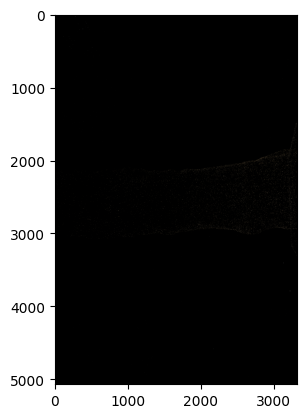

In [5]:
# this may take a while

with torch.no_grad():
    image = scene.render_image(image_num)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


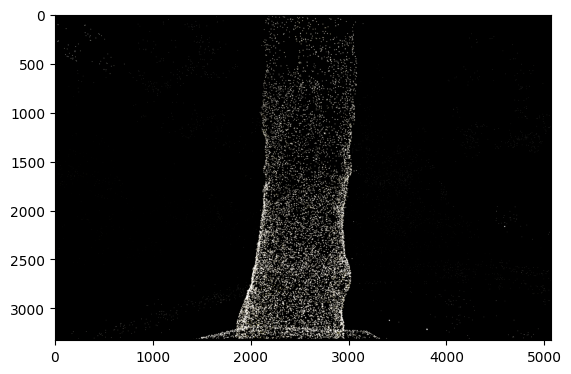

In [8]:
plt.imshow(image.cpu().detach().transpose(0, 1) * 256)